勾配降下法でポリタンクを探す
===
---

#### 参考URL
- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)
- [Goh, "Why Momentum Really Works", Distill, 2017.](https://distill.pub/2017/momentum/)

## 1. 準備
### 1.1. import

In [1]:
import sys
sys.path.append('..')

from geo_util import MapTile  # 地理院タイルを扱いやすくするために作った
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize

### 1.2. 関係する範囲の地理院タイルをダウンロード
できるだけ細かく取得したい。
dem5aがベストらしい。
http://maps.gsi.go.jp/help/pdf/demapi.pdf

In [2]:
from_tile, to_tile = [15, 29044, 12928], [15, 29051, 12935]
nabewari_tile = MapTile(from_tile, to_tile, zoom=15, tile_type="dem5a", ext="txt")

In [3]:
nabewari_map = MapTile([13, 7261, 3232], [13, 7262, 3233], zoom=13, tile_type="std", ext="png")

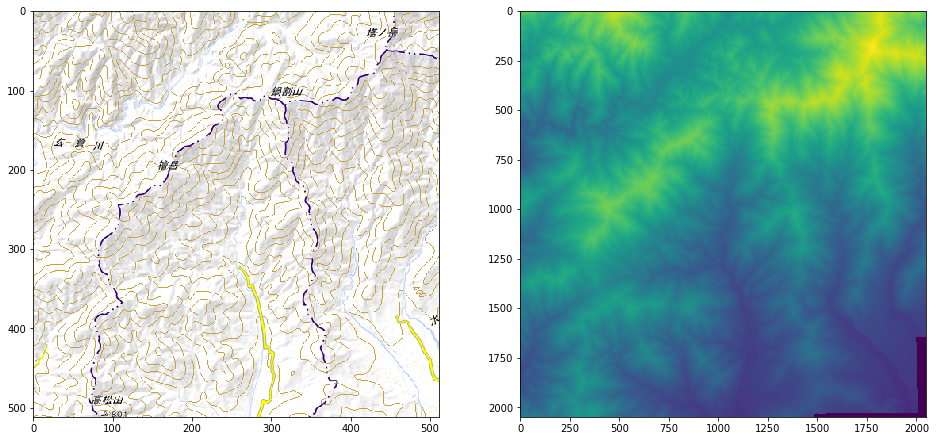

In [4]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(nabewari_map.data)
axarr[1].imshow(nabewari_tile.data, interpolation="none")

### 1.3. ポリタンクを落とした地点の座標を取得
現場の写真のExifより、以下の地点で落としたことが分かっている。

In [5]:
start_lat, start_lon = 35.437, 139.141

### 1.4. 緯度経度をピクセル座標に変換
参考：http://www.trail-note.net/tech/coordinate/

In [6]:
def latlon_to_pixel(lat, lon, zoom):
    L = 85.05112878
    x = 2**(zoom+7) * (1 + lon/180.)
    y = 2**(zoom+7) / np.pi * (- np.arctanh(np.sin(np.pi*lat/180.)) + np.arctanh(np.sin(np.pi*L/180.)))
    return x, y

In [7]:
start_x, start_y = latlon_to_pixel(start_lat, start_lon, 15)
print(start_x, start_y)

7436524.293688889 3310245.05259


これをダウンロードしてきた地理院タイル（`nabewari_tile`）のindexに変換する。

普通なら256で割った余りを取れば良いが、`nabewari_tile`は複数の地理院タイルを結合したものであることに注意する。

In [8]:
start_x = start_x - 256*from_tile[1]
start_y = start_y - 256*from_tile[2]
print(start_x, start_y)

1260.2936888886616 677.05258863


- indexに変換できたので、地図と合わせてプロットする。

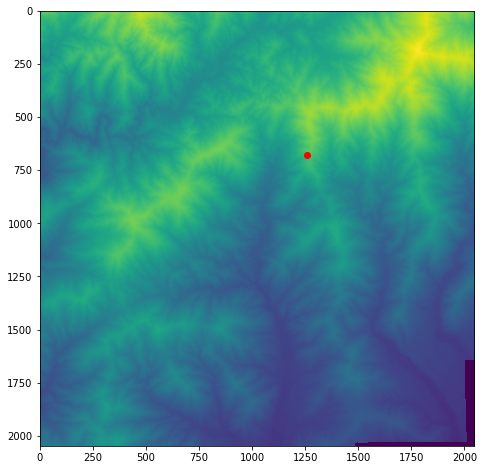

In [9]:
plt.imshow(nabewari_tile.data)
plt.scatter(start_x, start_y, color="red")

-> ちゃんと適切に計算できている（目視確認）

## 2. 勾配降下法
<img src="gradient_descent.png" width="600"></img>
画像：[Goh, "Why Momentum Really Works", Distill, 2017.](https://distill.pub/2017/momentum/)

### 2.1. 原理

初期地点を$(x_0, y_0)$として、以下のように勾配（偏微分）に基づいて移動を行う。$\epsilon$は1ステップごとの移動量を決めるパラメータである。
$$
\begin{align}
x_{k+1} = x_{k} - \epsilon \frac{\partial z}{\partial x} \\
y_{k+1} = y_{k} - \epsilon \frac{\partial z}{\partial y}
\end{align}
$$

### 2.2. 勾配の計算方法
地理院タイルでは格子点上の標高が記されている（下図の正方形の頂点）。その隙間を含む任意の地点$(x, y)$での勾配を知りたい（ポリタンクは格子点上だけを転がってくれる訳ではない）ので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。
<img src="../fig/grad.png", width=300></img>

(1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

   3点 $([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$


(2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

   3点 $([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

(1), (2)いずれの場合でも、勾配は隣の格子点同士の高さを単純に引き算したものになっている。

### 2.3. 勾配降下法の修正
勾配降下法をそのまま適用するのはあまりに単純すぎるので、以下のような修正を加えることにする。

####  (i) ランダムな方向転換
地理院タイルの分解能に現れない細かな地形や樹木等の影響に対応。

実装上は、平均0, 標準偏差 `direction_scale` $[rad]$ の正規分布に従う方向転換が行われるものとする。

#### (ii) ランダムな停止判定
勾配降下法は局所最小値に到達するまで停止しないが、ポリタンクは斜面上で停止する可能性ある。以下のように考える。

- 速度が0の時は確率1で停止する
- 速度$v>0$の時も停止する確率があり、その確率$p_{stop}(v)$は$v$に対して単調減少かつ0に漸近する。

これらの条件を満たす停止確率$p_{stop}(v)$は、例えば以下のように設定できる。

$$
p_{stop}(v) = e^{-\lambda v}
$$

$\lambda$が大きいほど以下のように停止確率は小さくなる。

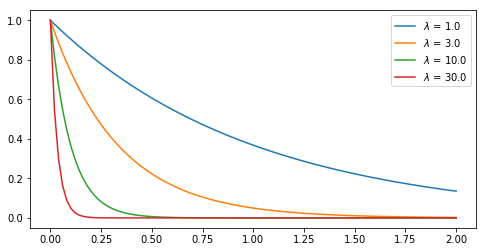

In [10]:
figsize(8, 4)
lambdas = [1.0, 3.0, 10.0, 30.0]
for l in lambdas:
    x = np.linspace(0.0, 2.0, 100)
    y = np.exp(- l * x)
    plt.plot(x, y, label="$\lambda$ = {}".format(l))
plt.legend()

####  (iii) モメンタム（参考：[Why Momentum Really Works](https://distill.pub/2017/momentum/)）
ポリタンクの移動速度は、現在地での勾配だけでなく過去の速度にも依存する。慣性。

(i) - (iii)に伴い、$\epsilon$だけでなく以下のようなパラメータを設定する必要が生じる。

- ランダムな方向転換の程度（`direction_scale` $[rad]$）：例えば$\pi / 12$にすると、方向転換が正面から±15度の範囲に収まる確率は68%
- 速度に応じた停止確率$p_{stop}(v)$を定めるパラメータ
- モメンタムの程度（"Why Momentum Really Works"のβ）


### 2.4. 勾配降下法の実装
クラスを作成する。各パラメータは変更可能だが、真の値は分からないので、後ほど様々な値を与えた上で集計する。

In [11]:
def rotated(x, y, theta):
    """ ベクトル(x, y)をthetaだけ回転させる。方向転換に使用する """
    rotation_matrix = np.matrix(((np.cos(theta), -np.sin(theta)),
                                 (np.sin(theta), np.cos(theta))))
    return np.array(rotation_matrix.dot(np.array([x, y])))[0]

In [12]:
class TankTrajectory():
    """ 初期位置と標高タイルとパラメータを指定して勾配降下法を実行するクラス
    Input:
        start: 転がり始める地点のピクセル座標のタプル（標高タイルのindexと対応させておく）
        maptile: 勾配降下法を実行する標高タイル
        epsilon: 1stepごとの位置の更新量に影響するパラメータ
        max_step: 最大ステップ
        stop_lambda: 停止条件の数式のλ
        momentum: モメンタムの係数（"Why Momentum Really Works"のβ）
        direction_scale: ランダムな方向転換の角度の標準偏差
    Attribute: .run()を実行すると、得られた軌道に基づいて以下の属性がセットされる
        .x_list: 軌道の各stepにおけるx座標のリスト
        .y_list: 軌道の各stepにおけるy座標のリスト
        .vel_list: 軌道の各stepにおける速度のリスト
        .end_x: 軌道の終点におけるx座標
        .end_y: 軌道の終点におけるy座標
    """
    
    def __init__(self, start, maptile, epsilon, max_step, stop_lambda, momentum=0.0, direction_scale=0.0):
        """ Constructor """
        self.start_x, self.start_y = start
        self.maptile = maptile
        self.epsilon = epsilon
        self.max_step = max_step
        self.stop_lambda = stop_lambda
        self.momentum = momentum
        self.direction_scale = direction_scale

    def run(self):
        """ 勾配降下法を実行 """
        x, y = self.start_x, self.start_y
        self.x_list, self.y_list = [x], [y]
        self.vel = 0
        self.vel_list = [self.vel]
        zx, zy = 0.0, 0.0  # for momentum

        for step in range(self.max_step):
            try:
                gx, gy = self.maptile.grad(x, y)
            except IndexError: # タイルからはみ出した
                break
            #  勾配降下法 (+ momentum)に基づいて位置を更新
            zx = self.momentum*zx + gx
            zy = self.momentum*zy + gy
            dx = self.epsilon * zx
            dy = self.epsilon * zy
            theta = np.random.normal(loc=0.0, scale=self.direction_scale)  # ランダムな回転角
            dx, dy = rotated(dx, dy, theta)  # 速度を回転させる
            x = x - dx
            y = y - dy
            # 速度
            self.vel = np.sqrt(dx**2 + dy**2)
            #  軌道を保存
            self.x_list.append(x)
            self.y_list.append(y)
            self.vel_list.append(self.vel)
            # 停止判定
            if self.is_stopped():
                break

        print("stopped at step={}".format(step))
        # 停止時の座標
        self.end_x, self.end_y = x, y

    def is_stopped(self):
        """ 停止判定 """
        #dx = self.x_list[-1] - self.x_list[-2]
        #dy = self.y_list[-1] - self.y_list[-2]
        #vel = np.sqrt(dx**2 + dy**2)  # 速度
        #prob_stop = np.exp( - self.stop_lambda*vel)
        prob_stop = np.exp( - self.stop_lambda*self.vel)
        # 確率prob_stopで停止。初期状態では停止しない
        return len(self.vel_list) > 1 and np.random.random() < prob_stop

- 使ってみる

In [13]:
t1 = TankTrajectory((start_x, start_y), nabewari_tile, epsilon=0.1, max_step=100000, stop_lambda=10, momentum = 0.9, direction_scale=np.pi/12)
t1.run()

stopped at step=171


- 実行結果を可視化してみる

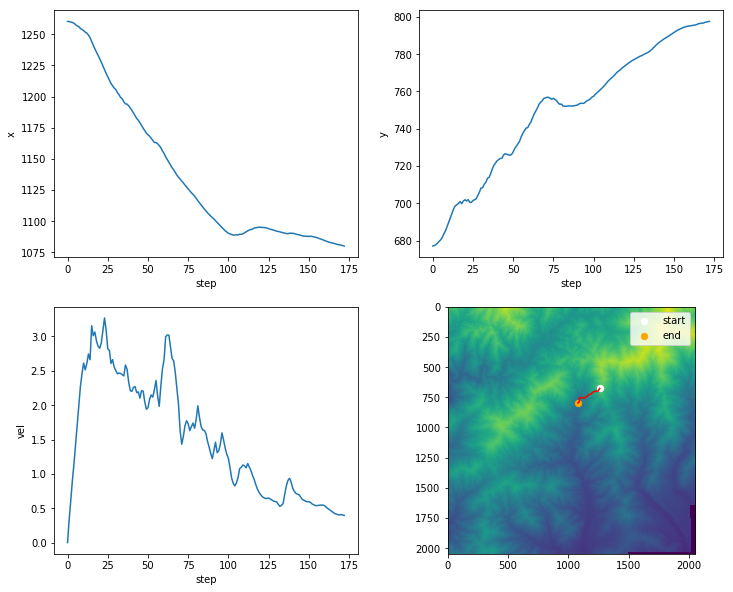

In [14]:
figsize(12, 10)
f, axarr = plt.subplots(2, 2)

# xの推移
axarr[0][0].plot(t1.x_list)
axarr[0][0].set_xlabel("step")
axarr[0][0].set_ylabel("x")
# yの推移
axarr[0][1].plot(t1.y_list)
axarr[0][1].set_xlabel("step")
axarr[0][1].set_ylabel("y")
# 速度の推移
axarr[1][0].plot(t1.vel_list)
axarr[1][0].set_xlabel("step")
axarr[1][0].set_ylabel("vel")
# 軌道をプロット
axarr[1][1].plot(t1.x_list, t1.y_list, color="red")
axarr[1][1].scatter(t1.start_x, t1.start_y, color="white", s=40, label="start")
axarr[1][1].scatter(t1.end_x, t1.end_y, color="orange", s=40, label="end")
axarr[1][1].legend()
axarr[1][1].imshow(nabewari_tile.data)

## 3. ランダムな初期位置の生成
勾配降下法を実行する準備が整ったので、これを

- 様々な初期位置（GPSの誤差などの不確実性があるので）
- 様々なパラメータ（真の値はよく分からないので）

で実行していくことになる。まずは様々な初期位置を生成する。

ポリタンクを落とした位置の推定座標をピークとしてもつ対称な二次元正規分布をベースとするが、ポリタンクが西側に転がったことは既知なので、東側に転がってしまうような初期位置は除外する。

In [15]:
start_x_list = np.random.normal(loc=start_x, scale=7, size=1000)
start_y_list = np.random.normal(loc=start_y, scale=7, size=1000)
start_list = np.c_[start_x_list, start_y_list]

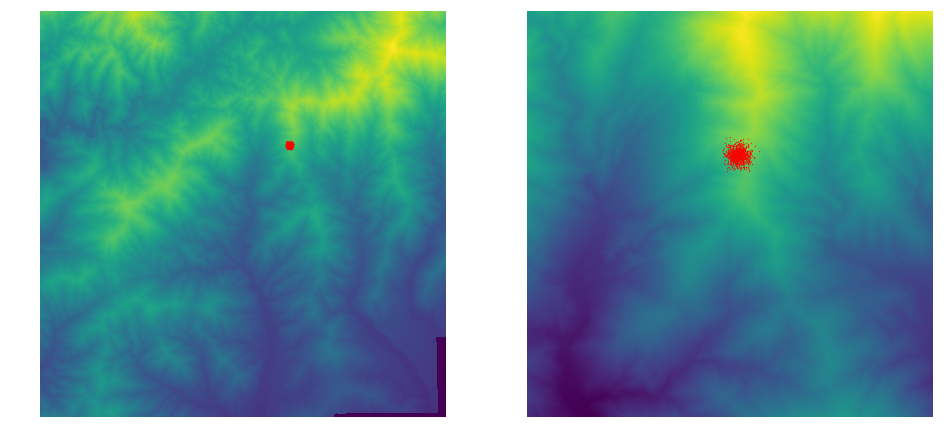

In [16]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(start_list[:, 0], start_list[:, 1], s=0.1, color="red")
axarr[1].imshow(nabewari_tile.data[500:1000, 1000:1500])
axarr[1].scatter(start_list[:, 0]-1000, start_list[:, 1]-500, s=0.1, color="red")

## 4. 様々なパラメータ・初期値で勾配降下法を実行

In [17]:
trajectory_list = []
for sx, sy in tqdm(start_list):
    trajectory = TankTrajectory((sx, sy), nabewari_tile, epsilon=0.1, max_step=100000,
                                stop_lambda=10, momentum = 0.7, direction_scale=np.pi/12)
    trajectory.run()
    trajectory_list.append(trajectory)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

stopped at step=121
stopped at step=210
stopped at step=229
stopped at step=210
stopped at step=83
stopped at step=207
stopped at step=238
stopped at step=150
stopped at step=244
stopped at step=199
stopped at step=253
stopped at step=234
stopped at step=240
stopped at step=209
stopped at step=125
stopped at step=137
stopped at step=131
stopped at step=222
stopped at step=231
stopped at step=130
stopped at step=261
stopped at step=242
stopped at step=173
stopped at step=150
stopped at step=243
stopped at step=109
stopped at step=233
stopped at step=240
stopped at step=97
stopped at step=227
stopped at step=255
stopped at step=165
stopped at step=232
stopped at step=77
stopped at step=230
stopped at step=246
stopped at step=248
stopped at step=160
stopped at step=204
stopped at step=214
stopped at step=121
stopped at step=153
stopped at step=239
stopped at step=225
stopped at step=205
stopped at step=0
stopped at step=281
stopped at step=147
stopped at step=80
stopped at step=255
stoppe

stopped at step=279
stopped at step=281
stopped at step=224
stopped at step=241
stopped at step=217
stopped at step=97
stopped at step=197
stopped at step=202
stopped at step=199
stopped at step=116
stopped at step=252
stopped at step=259
stopped at step=87
stopped at step=203
stopped at step=118
stopped at step=236
stopped at step=248
stopped at step=228
stopped at step=245
stopped at step=45
stopped at step=103
stopped at step=260
stopped at step=218
stopped at step=249
stopped at step=255
stopped at step=251
stopped at step=244
stopped at step=177
stopped at step=247
stopped at step=276
stopped at step=174
stopped at step=193
stopped at step=159
stopped at step=230
stopped at step=242
stopped at step=304
stopped at step=239
stopped at step=200
stopped at step=221
stopped at step=232
stopped at step=238
stopped at step=254
stopped at step=206
stopped at step=318
stopped at step=143
stopped at step=194
stopped at step=194
stopped at step=206
stopped at step=129
stopped at step=108
sto

stopped at step=275
stopped at step=232
stopped at step=270
stopped at step=234
stopped at step=259
stopped at step=207
stopped at step=97
stopped at step=119
stopped at step=103
stopped at step=113
stopped at step=53
stopped at step=244
stopped at step=236
stopped at step=241
stopped at step=81
stopped at step=201
stopped at step=184
stopped at step=238
stopped at step=244
stopped at step=219
stopped at step=187
stopped at step=182
stopped at step=106
stopped at step=263
stopped at step=256
stopped at step=94
stopped at step=123
stopped at step=113
stopped at step=210
stopped at step=238
stopped at step=267
stopped at step=298
stopped at step=196
stopped at step=231
stopped at step=242
stopped at step=201
stopped at step=130
stopped at step=211
stopped at step=250
stopped at step=245
stopped at step=214
stopped at step=240
stopped at step=137
stopped at step=84
stopped at step=166
stopped at step=267
stopped at step=141
stopped at step=132
stopped at step=112
stopped at step=236
stopp

In [18]:
len(trajectory_list)

1000

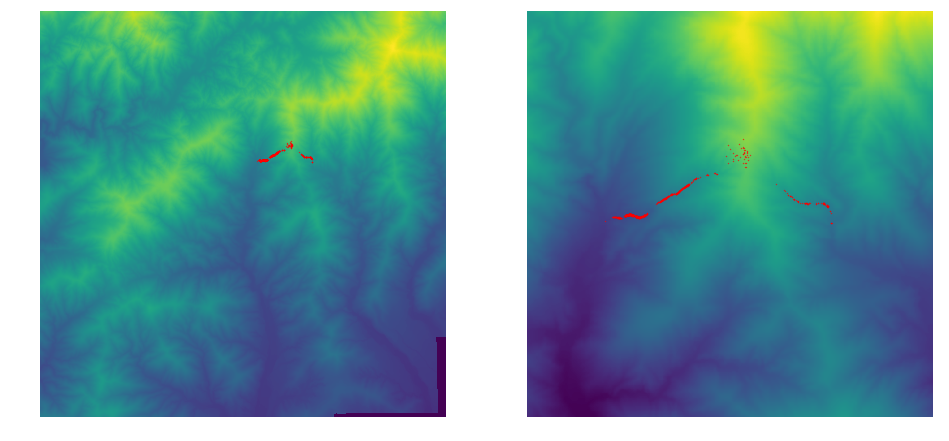

In [19]:
end_list = np.array([(t.end_x, t.end_y) for t in trajectory_list])

figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red")
axarr[1].imshow(nabewari_tile.data[500:1000, 1000:1500])
axarr[1].scatter(end_list[:, 0]-1000, end_list[:, 1]-500, s=0.1, color="red")

In [21]:
# 西側に転がったものだけ取り出す
filtered_list = [t for t in trajectory_list if t.start_x > t.end_x]
# filtered = filter(lambda t: t.start_x > t.end_x, trajectory_list)
print(len(filtered_list))

898


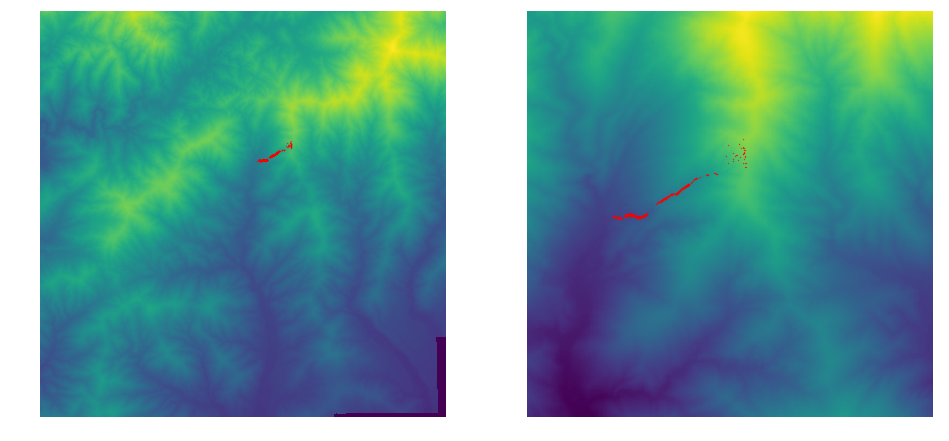

In [22]:
end_list = np.array([(t.end_x, t.end_y) for t in filtered_list])

figsize(16, 8)
f, axarr = plt.subplots(1, 2)
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red")
axarr[1].imshow(nabewari_tile.data[500:1000, 1000:1500])
axarr[1].scatter(end_list[:, 0]-1000, end_list[:, 1]-500, s=0.1, color="red")

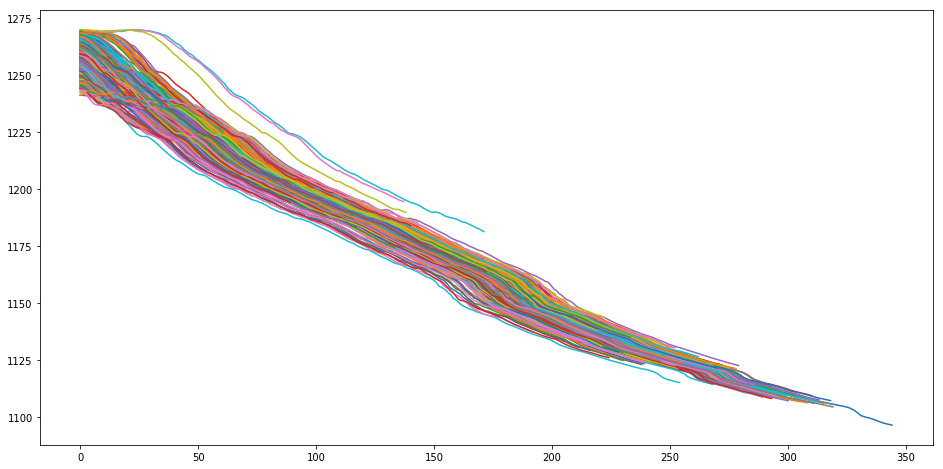

In [23]:
for t in filtered_list:
    plt.plot(t.x_list[:5000])

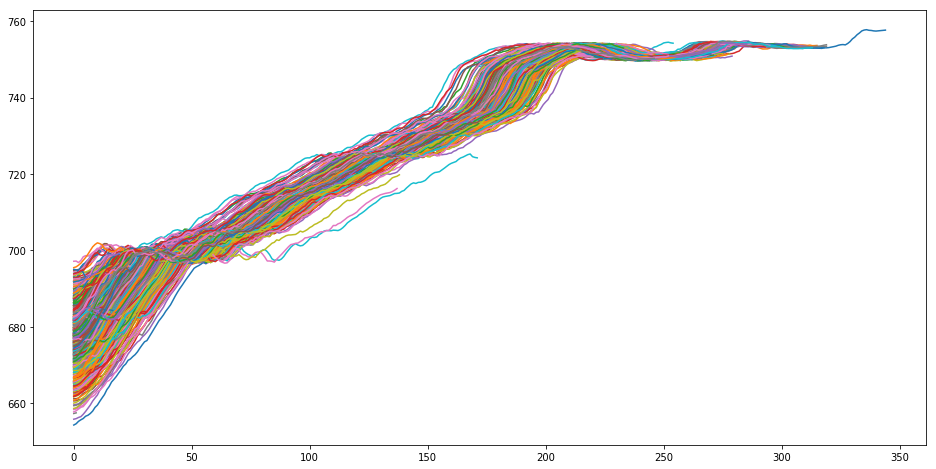

In [24]:
for t in filtered_list:
    plt.plot(t.y_list[:5000])

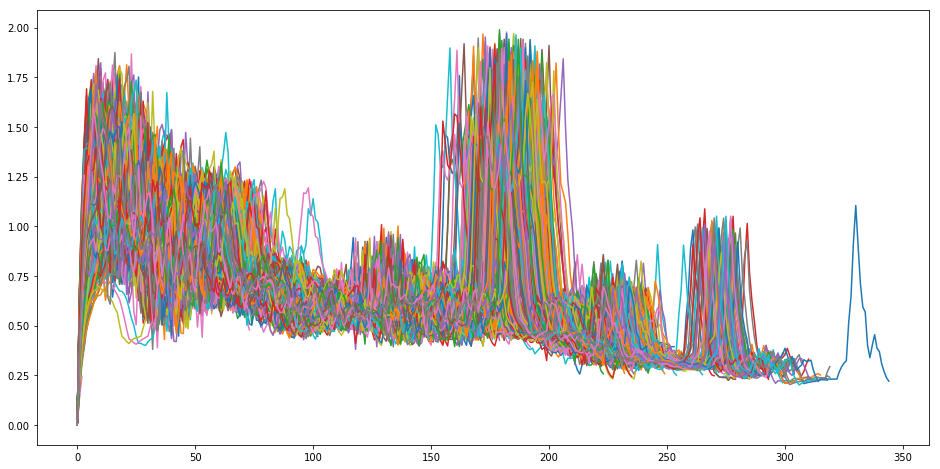

In [25]:
for t in filtered_list:
    plt.plot(t.vel_list[:5000])